<a href="https://colab.research.google.com/github/catPotat/rn-hg-gpt2-playground/blob/main/Huggingface_GPT_2_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About

Author: *N H Long*

This notebook is about testing GPT-2's ability to aid creativities.

This notebook is dedicated to the SS2 class I'm taking now.

The dateline for a published research is in May (more info later).

<br>

---

<br>
<img src="https://i.redd.it/j586af7nxvu41.jpg" alt="Watching a train model" height=300>

# 🏁 Initialize

In [ ]:
!nvidia-smi
import torch
torch.cuda.is_available()

Fri Mar  5 08:58:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers
# !pip install datasets
!pip install python-dotenv
from google.colab import output
output.clear()
import os
from dotenv import load_dotenv
!cp 'drive/My Drive/.env.gdrive' '.env'
load_dotenv()

True

# 🔧 Tuning

## 🍃 Obtaining data
After this you will get big text lines `text_entries`

In [ ]:
MONG_USER = os.getenv('MONG_ROUSER')
MONG_PWD  = os.getenv('MONG_ROPWD')
MONG_HOST = os.getenv('MONG_HOST')
MONG_PORT = os.getenv('MONG_PORT')

from pymongo import MongoClient
from bson.objectid import ObjectId

uri = f"mongodb://{MONG_USER}:{MONG_PWD}@{MONG_HOST}:{MONG_PORT}/dataDumpingGround"
client = MongoClient(uri)
client

MongoClient(host=['171.244.50.232:27017'], document_class=dict, tz_aware=False, connect=True)

### Pick a source

#### a) english pokedex

In [ ]:
db = client['dataSoup']
dataSoup_col = db["pot1"]
pokedex_text_entries_plain = dataSoup_col.find_one({'name': 'pokedex text_entries_plain'})

In [ ]:
text_entries = pokedex_text_entries_plain['content']
# text_entries

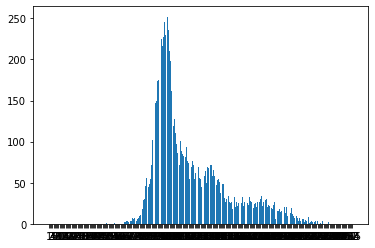

In [ ]:
entry_len = {}
for x in range(255):
    entry_len[x+1] = 0
 
for entry in text_entries:
    # if text_len := len(entry) in entry_len:
    text_len = len(entry)
    if text_len in entry_len:
        entry_len[text_len] += 1
    else:
        entry_len[text_len] = 1
entry_len
 
import matplotlib.pyplot as plt

plt.bar(range(len(entry_len)), list(entry_len.values()), align='center')
plt.xticks(range(len(entry_len)), list(entry_len.keys()))
plt.show()

#### b) someone's tweets

In [ ]:
db = client['dataDumpingGround']
tw_profile_col = db["twitterProfiles"]
tw_profile = tw_profile_col.find_one({'screen_name': 'billwurtz'})
tw_profile

{'Absent keys': ['withheld_in_countries', 'withheld_scope'],
 'Last updated': datetime.datetime(2021, 1, 21, 12, 15, 4, 208000),
 '_id': ObjectId('6004a17d0b73eae2a9b6c5b5'),
 'created_at': 'Fri Apr 29 09:57:13 +0000 2011',
 'default_profile': False,
 'default_profile_image': False,
 'description': 'is self',
 'favourites_count': 22852,
 'followers_count': 321129,
 'friends_count': 81,
 'id': 289853473,
 'listed_count': 352,
 'location': '',
 'name': 'bill wurtz',
 'profile_banner_url': 'https://pbs.twimg.com/profile_banners/289853473/1435339266',
 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1016862391823360000/BeQ1lMU7_normal.jpg',
 'protected': False,
 'screen_name': 'billwurtz',
 'statuses_count': 3095,
 'url': 'https://t.co/WGqYlp4ab6',
 'verified': True}

In [ ]:
from pprint import pprint
import re
from sys import maxsize as inf
text_entries = []
LIMIT = inf

tweet_col = db["twitterTweets"]
tweet_cursor = tweet_col.find({'Author_id': 289853473})
for tweet in tweet_cursor.limit(LIMIT):
    # pprint(tweet)
    text = tweet.get('full_text')
    if text.startswith('RT @'):
        continue
    text = re.sub(r'\@(.*?)\ ', '', text)
    text = re.sub(r'\#(.*?)\ ', '', text)
    text = re.sub(r'(https?:\/\/t.co\/)(.*)', '', text)
    text = re.sub(r'\n\nbill wurtz', '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\'', '', text)
    text_entries.append(text)
 
# text_entries

Visualize our data

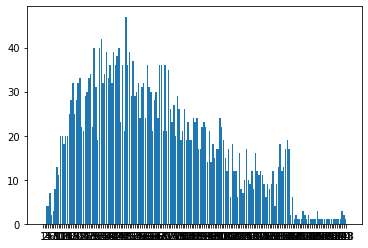

In [ ]:
entry_len = {}
for x in range(140):
    entry_len[x+1] = 0
 
for entry in text_entries:
    text_len = len(entry)
    if text_len in entry_len:
        entry_len[text_len] += 1
    else:
        entry_len[text_len] = 1
entry_len
 
import matplotlib.pyplot as plt
 
plt.bar(range(len(entry_len)), list(entry_len.values()), align='center')
plt.xticks(range(len(entry_len)), list(entry_len.keys()))
plt.show()

#### c) pictures as text

[pkm refs](https://colab.research.google.com/drive/1SdgyibJJKpPmMFX9UD1r7ZOZJHJfbm1z?authuser=2#scrollTo=oLfKBltYZVeq)

In [ ]:
!mkdir -p datasets/{fragments,all-pics}/
# !unzip "drive/My Drive/datasets/Eeveelutions/sap1231-251020.zip" -d datasets/fragments/
# !unzip "drive/My Drive/datasets/Eeveelutions/evhub#evlution-pics.zip" -d datasets/fragments/
!unzip "/content/drive/MyDrive/datasets/gpt2-experiments/synthed-pics.zip" -d datasets/
output.clear()
'OK'

'OK'

In [ ]:
import os
import shutil
from tqdm import tqdm
from PIL import Image
import math

IMG_WIDTH = 64
IMG_HEIGHT = 64
LINE_SPLIT_CHAR = '.'
PIXEL_SPLIT_CHAR = ' '
IMAGE_SPLIT_CHAR = '\n'
CHAR_CODE_SHIFT = 48 # starts from "0"
IMAGES_PATH = 'datasets/synthed-pics/'
IMG_TXT_PATH = f'drive/MyDrive/datasets/Eeveelutions/all-images-{IMG_WIDTH}.txt'
IMG_TXT_PATH = f'drive/MyDrive/datasets/gpt2-experiments/synthed-poster-64-space.txt'

In [ ]:
for root, dirs, files in tqdm( os.walk('./datasets/', topdown=False) ):
    for name in files:
        if 'SoloEevee/Umbr' not in root: continue
        if 'NotEevee' in root: continue
        if 'Grouped' in root: continue
        file_path = os.path.join(root, name)
        # print(file_path)
        shutil.copyfile(file_path, os.path.join(IMAGES_PATH, name))

108it [00:00, 269.37it/s]


In [ ]:
text_entries = []
for f in tqdm( os.listdir(IMAGES_PATH) ):
    if f.split('.')[-1] not in ['png', 'gif', 'jpg', 'jpeg']:
      continue
    image = Image.open(os.path.join(IMAGES_PATH, f)).convert('RGBA')
    # ratio check
    rtio = image.size[0] / image.size[1] # width/height
    gndRtio = IMG_WIDTH / IMG_HEIGHT
    if rtio > gndRtio*1.6 or rtio < 1/gndRtio*0.7:
        continue
    image = image.resize((IMG_WIDTH, IMG_HEIGHT))
    pixels = image.load()
    lines = []
    for y in range(IMG_HEIGHT):
        split = []
        for x in range(IMG_WIDTH):
            s = '~'
            color = pixels[x, y]
            if len(color) < 4 or color[3] > 128:
                r, g, b = color[0:3]
                mR = math.floor(r/64) # 6-bit color
                mG = math.floor(g/64)
                mB = math.floor(b/64)
                c = 0;
                c += mR
                c = c << 2
                c += mG
                c = c << 2
                c += mB
                s = chr(c+CHAR_CODE_SHIFT)
            split.append(s)
        lines.append(PIXEL_SPLIT_CHAR.join(split))
    out_ = LINE_SPLIT_CHAR.join(lines)
    text_entries.append(out_)
    mirrored = LINE_SPLIT_CHAR.join(
        [l[::-1] for l in lines]
    )
    text_entries.append(mirrored)
    
with open(IMG_TXT_PATH, 'w+') as f:
    f.write(IMAGE_SPLIT_CHAR.join(text_entries))

100%|██████████| 8000/8000 [00:48<00:00, 164.24it/s]


In [ ]:
output = ''
for f in tqdm( os.listdir(IMAGES_PATH) ):
    ext = f.split('.')[-1]
    if ext not in ['png', 'gif', 'jpg', 'jpeg']:
      continue
    image = Image.open(os.path.join(IMAGES_PATH, f)).convert('RGBA')
    pixels = image.load()
    width = image.size[0]
    height = image.size[1]
    lines = []
    for y in range(height):
        padLength = len(str(width))
        padded = str(y).zfill(padLength)
        split = [padded + 'd']
        for x in range(width):
            color = pixels[x, y]
            s = '~'
            if len(color) < 4 or color[3] > 128:
                r, g, b = color[0], color[1], color[2]
                if r == 85 and g == 85 and b == 85:
                    s = 'a' # use grayscale character 1
                elif r == 170 and g == 170 and b == 170:
                    s = 'b' # use grayscale character 2
                else: # use one of 64 color characters
                    mR = math.floor(r/64)
                    mG = math.floor(g/64)
                    mB = math.floor(b/64)
                    c = 0;
                    c += mR
                    c = c << 2
                    c += mG
                    c = c << 2
                    c += mB
                    s = chr(c+33)
            split.append(s)
        lines.append(' '.join(split))
    reversed = []
    for line in lines:
        reversed.insert(0, (line.replace('d ', 'u ', 1)))
    output += '\n'.join(lines)
    # output += '\n'.join(reversed)
print('saving output')
with open('all-images.txt', 'w') as output_file:
    output_file.write(output)
print('done !')

100%|██████████| 8000/8000 [00:41<00:00, 193.15it/s]


saving output
done !


In [ ]:
with open(IMG_TXT_PATH, 'r') as f:
    content = f.read()
    text_entries = content.split(IMAGE_SPLIT_CHAR)

text_entries

#### b) wattpad stories

In [ ]:
TEXT_PATH = '/content/drive/MyDrive/datasets/wattpad'

In [ ]:
text_entries = []

for root, dirs, files in os.walk(TEXT_PATH, topdown=False):
    for name in files:
        file_path = os.path.join(root, name)
        print(file_path)
        with open(file_path) as fp: 
            # text_entries += fp.read() +'\n'
            for line in fp:
                text_entries.append(line.strip())

/content/drive/MyDrive/datasets/wattpad/Doki-Doki-Literature-Club-Full-script-wattpad_172296185.txt
/content/drive/MyDrive/datasets/wattpad/It-Started-with-a-Selfie-_larry-stylinson-a.u._-wattpad_22320751.txt
/content/drive/MyDrive/datasets/wattpad/The-Crooked-Oak-Undertale-Script-Book-wattpad_177090691.txt
/content/drive/MyDrive/datasets/wattpad/Sold-at-first-sight_-_-_-wattpad_43723.txt
/content/drive/MyDrive/datasets/wattpad/Perfect-Fate-wattpad_16490622.txt
/content/drive/MyDrive/datasets/wattpad/Bản sao của Doki-Doki-Literature-Club-Full-script-wattpad_172296185.txt
/content/drive/MyDrive/datasets/wattpad/Bản sao của It-Started-with-a-Selfie-_larry-stylinson-a.u._-wattpad_22320751.txt


## 🚋 Names and paths

In [ ]:
MODEL_NAME = "gpt2-medium"
MODEL_SAVE_PATH = 'drive/MyDrive/model-checkpoints/gpt2-med-wattpad/'
TOK_PATH = MODEL_SAVE_PATH + "tok/"
TRAIN_PATH = 'train_dataset.txt'
TEST_PATH = 'test_dataset.txt'

In [ ]:
# ALTERNATIVE
MODEL_SAVE_PATH = 'drive/MyDrive/model-checkpoints/gpt2-umbrpics/'
TRAIN_PATH = '/content/drive/MyDrive/datasets/Eeveelutions/umbr-64-mirror/train_dataset.txt'
TEST_PATH = '/content/drive/MyDrive/datasets/Eeveelutions/umbr-64-mirror/test_dataset.txt'

### 📄 Build txt file

In [ ]:
from sklearn.model_selection import train_test_split

train_ds, test_ds = train_test_split(text_entries, test_size=0.05, shuffle=True) 

print(f"Train dataset length: {len(train_ds)}")
print(f"Test dataset length: {len(test_ds)}")

Train dataset length: 57994
Test dataset length: 3053


In [ ]:
longest_len = 0

def build_text_files(lines, dest_path):
    global longest_len
    f = open(dest_path, 'w+')
    data = ""
    for line in lines:
        data += line + '\n' # IMAGE_SPLIT_CHAR
        
        # assign max length
        if len(line) > longest_len:
            longest_len = len(line)
    f.write(data)

build_text_files(train_ds, TRAIN_PATH)
build_text_files(test_ds, TEST_PATH)

## 🧠 The model
Get the available $MODEL_NAME model

In [ ]:
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained(
    MODEL_NAME
    # MODEL_SAVE_PATH + 'checkpoint-40000/'
)
# model

### 🪓 Tokenizer

#### a) Train a tokenizer

[văn bản liên kết](https://huggingface.co/blog/how-to-train)

In [ ]:
from tokenizers import ByteLevelBPETokenizer

tok_trainer = ByteLevelBPETokenizer()
tok_trainer.train(files=[TRAIN_PATH, TEST_PATH],
                vocab_size=2000, min_frequency=1,)
!mkdir -p 'tok/'
tok_trainer.save_model('tok/', "igptkinda")
!mkdir -p $TOK_PATH
!cp 'tok/igptkinda-vocab.json' $TOK_PATH/vocab.json
!cp 'tok/igptkinda-merges.txt' $TOK_PATH/merges.txt

In [ ]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained(TOK_PATH)
tokenizer.encode("F90.F0G")

[37, 24, 15, 13, 37, 15, 38]

#### b) Pretrained

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# tokenizer.encode(" 9 I J J : : J.J J J J J ")

## 🚧 Training

API docs: [Trainer](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments) ,
[Torch optim](https://pytorch.org/docs/stable/optim.html)


### 📚 .txt to _dataset

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling

train_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=TRAIN_PATH,
    block_size=tokenizer.model_max_length
)
test_dataset = TextDataset(
    tokenizer=tokenizer,
    file_path=TEST_PATH,
    block_size=tokenizer.model_max_length
)
collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=False,
)

/usr/local/lib/python3.7/dist-packages/transformers/data/datasets/language_modeling.py:58: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/language-modeling/run_mlm.py
  FutureWarning,
Token indices sequence length is longer than the specified maximum sequence length for this model (1146864 > 1024). Running this sequence through the model will result in indexing errors


### 🤙 Evaluation callbacks


In [ ]:
from nlp import load_dataset
test = load_dataset('wikitext', 'wikitext-2-raw-v1', split='test')
encodings = tokenizer('\n\n'.join(test['text']), return_tensors='pt')

In [ ]:
max_length = model.config.n_positions
stride = 512

lls = []
for i in tqdm(range(0, encodings.input_ids.size(1), stride)):
    begin_loc = max(i + stride - max_length, 0)
    end_loc = min(i + stride, encodings.input_ids.size(1))
    trg_len = end_loc - i    # may be different from stride on last loop
    input_ids = encodings.input_ids[:,begin_loc:end_loc].to(device)
    target_ids = input_ids.clone()
    target_ids[:,:-trg_len] = -100

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)
        log_likelihood = outputs[0] * trg_len

    lls.append(log_likelihood)

ppl = torch.exp(torch.stack(lls).sum() / end_loc)

### 🎢 GD!

In [ ]:
from transformers import Trainer

class MyTrainer(Trainer):
    def compute_loss(self, *args, **kwargs):
        a = super().compute_loss(*args, **kwargs)
        print(args)
        print(kwargs)
        print(a)
        return a

In [ ]:
from transformers import Trainer, TrainingArguments, get_scheduler
from torch import optim

training_args = TrainingArguments(
    output_dir=MODEL_SAVE_PATH,
    overwrite_output_dir=True,
    num_train_epochs=5,
    # max_steps=80_000,
    save_steps=200,
    logging_steps=10,
    evaluation_strategy="steps",

# Turn down on memory usage
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    adafactor=True
)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = get_scheduler("polynomial", optimizer, num_warmup_steps=1000,
                          num_training_steps=0) # ?

trainer = Trainer(model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    # optimizers=(optimizer, scheduler),
    # compute_metrics=[Perplexity],
    # model_init=[Trainer.evaluate],
    data_collator=collator,
)
trainer.train()

RuntimeError: ignored

In [ ]:
trainer.save_model()

# 🧪 Testing

In [ ]:
from transformers import pipeline, set_seed

generator = pipeline('text-generation', model=MODEL_SAVE_PATH + '',
                     tokenizer=tokenizer)
set_seed(6110)

## a) Text test

In [ ]:
generator("", max_length=50, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': "If you have read my previous writing, you know that I'm not going to read any of it. Not since I've read the books and have spent some time talking to these people. I know that if I was to say anything stupid..."},
 {'generated_text': 'The Pink Queen?\n"I\'ll go get two, sweetie." I smiled.\n"Just remember where you are right now, okay?" He asked.\nWhen I told her we were going to meet again she shrugged and shook her'},
 {'generated_text': '\nAs always, I like to let everyone know that my AU is not my fault!\n"It\'s nice to be a part of the family. It\'s a huge privilege to be so close to everyone..."\n“You were just'},
 {'generated_text': 'What would you like to know more? (sighing) “I don’t get it.”\n(sighs, turns to look at her) "No, it wasn\'t her fault..."\n"Ah'},
 {'generated_text': '(stands up and leaves the room) “What?”\nP0 just jumps out of the bathroom, grabs P1\'s hand and walks out.\n"I\'m not sure that\'s fair, P0..." She glared'}]

https://github.com/huggingface/transformers/issues/1407

## b) Image test

In [ ]:
CONTRAST = 64
BRIGHTNESS = 24
def reconstruct_from(text, path, img_w=0, img_h=0):
    lines = text.split(LINE_SPLIT_CHAR)
    width = img_w if img_w else len( max(lines, key=len) )
    height = img_h if img_h else len(lines)
    pixels = []
    for y in range(height):
        for x in range(width):
            pixels.append((0, 0, 0, 0))
    for index, line in enumerate(lines):
        line = line.split(PIXEL_SPLIT_CHAR) if PIXEL_SPLIT_CHAR  else line
        for x in range(len(line) - 1):
            s = line[x + 1]
            try:
                if s == '~': continue
                r = g = b = 0
                c = ord(s[0])-CHAR_CODE_SHIFT
                b = (c & 3) * CONTRAST + BRIGHTNESS
                c = c >> 2
                g = (c & 3) * CONTRAST + BRIGHTNESS
                c = c >> 2
                r = (c & 3) * CONTRAST + BRIGHTNESS
                i = (index*width) + x
                pixels[i] = (r, g, b, 255)
            except: 
                print('fuck')
    image = Image.new('RGBA', (width, height))
    image.putdata(pixels)
    image.save(path)
    return image
# reconstruct_from(text_entries[-1], "test.png")

In [ ]:
genner = generator("", max_length=950, num_return_sequences=5)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:
i = 4

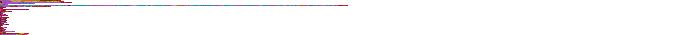

In [ ]:
reconstruct_from(genner[i]['generated_text'].strip(), "generated.png")

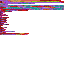

In [ ]:
reconstruct_from(genner[i]['generated_text'].strip(), "generated.png", IMG_WIDTH, IMG_HEIGHT)